# Continuous Blackjack

In this notebook, the continuous blackjack game, which was introduced in *G-Research Virtual Quant Finance Algorithmic Challenge (Japan, Online)* will be discussed. This is a partial summary of  [Mu Zhao's note](https://arxiv.org/abs/2011.10315) who completed the math Ph.D. in Stony Brook University with me and attended this challenge together as a team. I wrote this note for myself to achieve the concrete understanding on this problem with the practice on programming.

The problem is described as follows. Let $\{P_0,\cdots,P_{n-1}\}$ be players in the game. Then we will repeat the following game for $N$ times.
1. First, we choose each player's turn using a bijection $\sigma : \{0,\cdots,n-1\} \to \{0,\cdots,n-1\}$. Then the game proceeds with the order of $(P_{\sigma(0)},\cdots,P_{\sigma(n-1)})$.
2. In each player's turn, the player will receive the random number that is uniformly distributed in $[0,1]$. You can receive cards as many as you want, but if you bust (i.e. if the sum of your hands is bigger than 1), then you will automatically lose the game. Your goal is to be a player with the maximum hand that is not busted after all players finished their turn.
3. In your turn, you can see all of your previous players' hands. 
4. For each game, the winner will receive a point. 
5. After $N$ games are finished, we compute the total score and determine the final winner of this game.

**Question:** What is the best way to play this game?

As a player, there are some *trivial* facts for this game.

1. Since only the first place will get rewarded, each player will keep drawing more cards as long as their hand is smaller than any of previous player's hand. 
2. Each player needs to play more aggressively if there are more players waiting as they have the higher possibility to be beat by other players.
3. There will be always a winner.

## Simple Case - 2 Players

As usual, we start approaching this problem in a simple case. So assume that there are only 2 players. In the 2nd player's point of view, the strategy is fixed as follows.

* If the 1st player already busted, then the 2nd player always wins.
* If this is not the case, then the 2nd player has no choice except drawing more cards so that one can hopefully achieve hands greater than the 1st player's. 

Therefore, the 2nd player's strategy is deterministic. Now, let's consider the 1st player's point of view. We can first try to use *a brute force*. In other words, we repeat the game with different thresholds and choose the maximizer of winning probability. Here, we used Cython to increase the performance of the code.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from numpy import int64, float64
from itertools import permutations

In [2]:
# Initialize the random number generator

np.random.seed(1)

In [3]:
%load_ext Cython

In [4]:
%%cython

from libc.stdlib cimport rand, RAND_MAX

cdef double two_player_game(const double threshold, const long rounds):
    cdef double hand0, hand1, T, winning = 0
    cdef long r
    for r in range(rounds):
        hand0 = 0
        while hand0 < threshold:
            hand0 += rand()/float(RAND_MAX)
        if hand0 > 1:
            continue
        hand1 = 0
        while hand1 < hand0:
            hand1 += rand()/float(RAND_MAX)
        if hand1 > 1:
            winning += 1
            continue
    return winning / rounds

cpdef (double, double) optimalThreshold_simple(const long num_games, const long num_mesh):
    cdef double res = 0, p = 0, p_sim = 0, x
    cdef long i
    for i in range(num_mesh):
        x = (1.0*i)/num_mesh
        p_sim = two_player_game(x, num_games)
        if p_sim > p:
            res = x
            p = p_sim
    return res, p

In [5]:
num_games = 500000
num_mesh = 201
res, p = optimalThreshold_simple(num_games, num_mesh)
print(f'optimal threshold = {res} with the winning probability {p}')

optimal threshold = 0.5522388059701493 with the winning probability 0.42606


As we can see, choosing a threshold as 0.5522388.. will maximize the winning probability of the 1st player. In short, the 1st player needs to keep drawing as long as the total sum is smaller than the threshold. </br>
But this argument is hard to be generalized for $n$-players case. So let's take a look at the problem in a different viewpoint.

## Preparation

Let $$X_i \sim U[0,1]$$

be i.i.d. random variables and $S_n = \sum_{i = 1}^n X_i$. If $\tau(t)$ is the stopping time for $S_n$ so that $S_n \ge t$. In other words,
$$ \tau(t) = \inf\{n~|~S_n \ge t\}$$
Then we want to compute
$$F(x,y) = \mathbb{P}[S_{\tau(x)} \le y]$$
Now, we can see that
$$\begin{align*} 
F(x,y) = \mathbb{P}[S_{\tau(x)} \le y] &= \mathbb{P}[S_{\tau(x)} \le y, \tau(x) = 1]+\mathbb{P}[S_{\tau(x)} \le y, \tau(x) > 1]\\
&=\mathbb{P}[x\le X_1 \le y] + \int_{0}^x\mathbb{P}[S_{\tau(x)}-t \le y-t~|~S_1=t]dt\\
&=y-x + \int_0^xF(x-t,y-t)dt
\end{align*}$$
Also, we have a boundary condition $F(0,y) = y$. (Note that we only consider the case when $0 \le x \le y \le 1$)

First, we have the uniqueness of the solution. If $F_1, F_2$ are solutions and we set $\xi = F_1 - F_2$, one can see that $\xi$ is the solution for
$$\xi(x,y) = \int_0^x \xi(x-t,y-t)dt$$
with $\xi(0,y) = 0$. 

If $\xi$ is not trivial, then we can choose $$0\le x_0 \le y_0 \le 1$$ such that $$0<\xi(x_0,y_0) = \sup_{0\le t \le x_0} \xi(x_0-t,y_0-t)$$

But then we have the following from the equation.

$$0 < \xi(x_0,y_0) \le x_0 \sup_{0\le t \le x_0} \xi(x_0-t,y_0-t)$$

Since $0\le x_0 \le 1$, it implies that $x_0 = 1$. But this is a contradiction since $\xi(1,y) = 0$. 

Now, we only need to find the solution for 
$$F(x,y) = y-x + \int_0^xF(x-t,y-t)dt$$
with $F(0,y) = y$. By setting 
$$G(x,y) := \frac{F(x,y)}{y-x}$$
we have $$G(x,y) = 1 + \int_0^x G(x-t,y-t)dt$$ with $G(0,y) = 1$. If we further assume that $G(x,y)$ is independent to $y$, then the equation becomes
$$G(x) = 1 + \int_0^xG(x-t)dt = 1 + \int_0^xG(t)dt$$ with $G(0) = 1$. As a result, we can get the solution as
$$F(x,y) = (y-x)G(x) = (y-x)e^x$$

Now, we can apply this result for 2-players case. As observed, the 2nd player's strategy is determined so the 1st player wins the game if and only if the 2nd player busts. If the 1st player is playing a game with a threshold $t$, then the winning probability is computed as follows.

$$\begin{align*}
f(t) = \mathbb{P}[\text{the 1st player wins with threshold }t] &= \mathbb{P}[\text{the 1st player did not bust and the 2nd player busts}]\\ &= \int_t^1 \mathbb{P}[S_{\tau(t)} \in dh]\mathbb{P}[S_{\tau(h)} > 1] \\ &= \int_t^1 \partial_h F(t,h) \cdot (1-F(h, 1))dh\\ &= \int_t^1 \partial_h F(t,h) \cdot (1-F(h, 1))dh \\ &= e^t\int_t^1 (1-(1-h)e^h)dh \\ &= e^t\left(1-t - e + (2-t)e^t\right)\end{align*}$$

Now we will choose $t$ that maximizes $f(t)$ by solving

$$0 = \partial_tf(t) = e^t(1-e-t+(2-t)e^t -1 +(1-t)e^t)$$

which is equivalent to $$e + t = (3-2t)e^t$$

This equation can be solved numerically as follows. Here, the secant method is used. Actually, it is better to use other packages like Scipy, but it is implemented here as a practice. (But again, *do not reinvent the wheel)*.

In [6]:
%%cython

cpdef double solve_secant(f, long num_iter = 100000, double gap_size = 1e-5, double error_bound = 1e-10, int verbose = 0):
    cdef long i
    cdef double sec, p = 1
    for i in range(num_iter):
        if abs(f(p)) < error_bound:
            if verbose > 0:
                print(f'Iteration terminated in {i} steps')
            break
        sec = (f(p) - f(p - gap_size))/gap_size
        p -= f(p)/sec
    return p

In [7]:
f = lambda t : np.e + t - (3-2*t)*np.exp(t)
P = lambda t : np.exp(t) * (1-t-np.e + (2-t)*np.exp(t))

In [8]:
T = solve_secant(f, verbose = 1)
print(f'The winning probability is optimized by the threshold {T} as {P(T)}')

Iteration terminated in 5 steps
The winning probability is optimized by the threshold 0.5705565282653253 as 0.424985742633163


As we can see, the threshold 0.57055.. maximizes the probability of winning. This result is very close to what we achieved previously.

## General Case - Equilibrium

Previous argument gives the way to handle the general case. So assume that there are $n$-players $\{P_1,\cdots,P_n\}$. From the previous argument, we know the strategies for players $P_{n-1}$ and $P_n$. Using this information, player $P_{n-2}$ can compute the optimal threshold. And this process will continue to $P_1$. As a result, we can compute the optimal threshold for all $\{P_k\}_{1\le k \le n}$. Let $T_k$ be the optimal threshold for player $P_{n-k}$. From the previous argument, we know that $T_1 \approx 0.5705565$ and $T_0 = 0$. After then, we can derive the following.

$$\begin{align*}
f_k(t) = \mathbb{P}[\text{The player }P_{n-k}\text{ wins with threshold }t] &= \mathbb{P}[\text{the player }P_{n-k}\text{ did not bust and all other players }\{P_i\}_{i >n-k}\text{ bust}]\\ &= \int_t^1 \mathbb{P}[S_{\tau(t)} \in dh]\prod_{i < k}\mathbb{P}[S_{\tau(\max(T_i,h))} > 1]\\ &= e^t\int_t^1 \prod_{i < k}(1-F(\max(T_i,h), 1))dh\end{align*}$$

Also, we know that $T_i$ is increasing in $i$ due to the fact that *we need to play more aggressively when there are more remaining players*. As a result, we only have to consider the case when $t \ge T_{k-1} \ge \cdots \ge T_0 = 0$. It simplifies the equation as

$$f_k(t) = e^t\int_t^1 (1-F(h, 1))^kdh = e^t\int_t^1 (1-(1-h)e^h)^kdh$$

and the maximizer is obtained when $\partial_tf_k = 0$, which is equivalent to $$\int_t^1 (1-(1-h)e^h)^kdh = (1-(1-t)e^t)^k$$

Therefore, we need to compute $t$ satisfying the equation above.

In [9]:
%%cython
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

import numpy as np
cimport numpy as np
import scipy

def F(k):
    f = lambda t : (1-(1-t)*np.exp(t))**k
    return lambda t : scipy.integrate.quad(f, t, 1)[0] - f(t)

cpdef double[:] generate_Nash_thresholds(long m):
    cdef: 
        double[:] res
        long i
    res = np.zeros(m, dtype = np.float64)
    for i in range(m-2,-1,-1):
        res[i] = scipy.optimize.fsolve(F(m-1-i), 1)[0]
    return res

In [10]:
np.array(generate_Nash_thresholds(10))

array([0.87300813, 0.86255762, 0.84990029, 0.83419051, 0.81405923,
       0.78711137, 0.74867099, 0.68791554, 0.57055653, 0.        ])

## Some Computations

In [11]:
%%cython
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

from libc.stdlib cimport rand, RAND_MAX
    
import numpy as np
cimport numpy as np

cpdef double[:] sampling(long N):
    cdef double[:] res = np.zeros(N, dtype = np.float64)
    cdef long i
    for i in range(N):
        res[i] = rand()/float(RAND_MAX)
    
    return res

<AxesSubplot:ylabel='Count'>

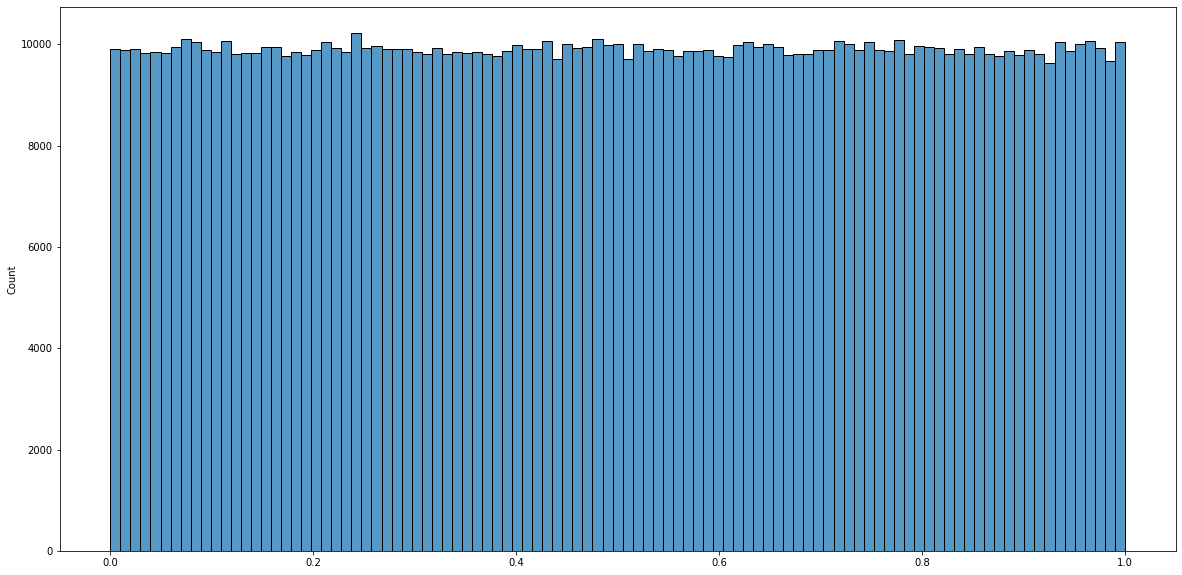

In [12]:
A = np.asarray(sampling(1000000))
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(A, ax = ax)

In [13]:
%%cython
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

from libc.stdlib cimport rand
cdef extern from "limits.h":
    int RAND_MAX
import numpy as np

cpdef double[:] simulation(long num_games, double threshold):
    cdef double[:] res = np.zeros(num_games, dtype = np.float64)
    cdef double hand
    
    for i in range(num_games):
        hand = 0
        while hand < threshold:
            hand += rand() / float(RAND_MAX)
        res[i] = hand
    return res

probability to get busted = 0.555146


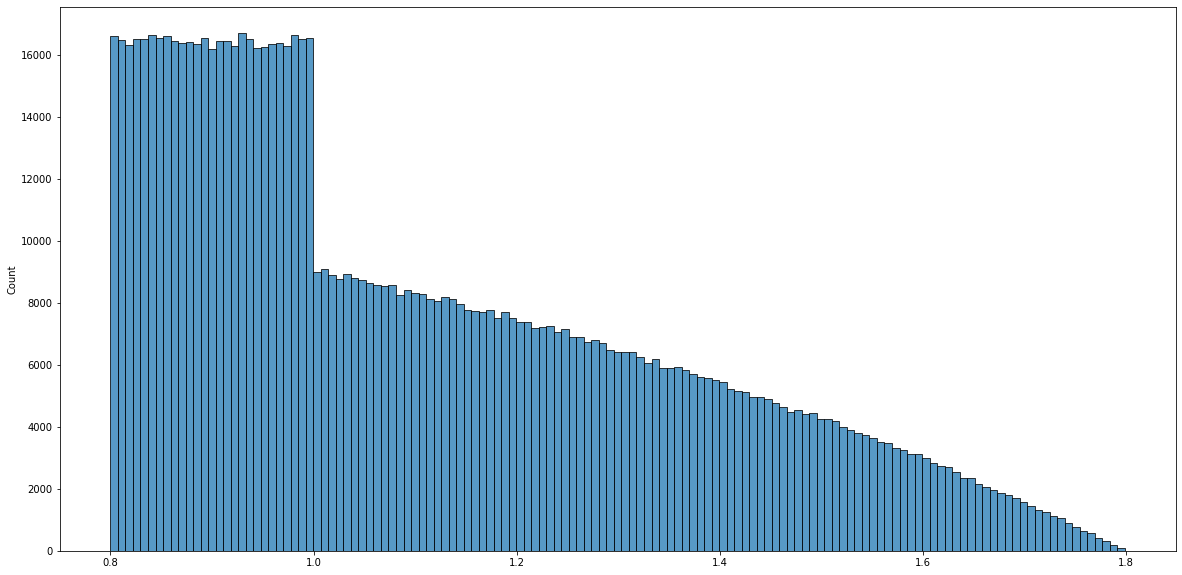

In [14]:
A = np.asarray(simulation(1000000, 0.8))
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(A, ax = ax)
print(f'probability to get busted = {(A>1).sum()/(A.size)}')

probability to get busted = 0.395923


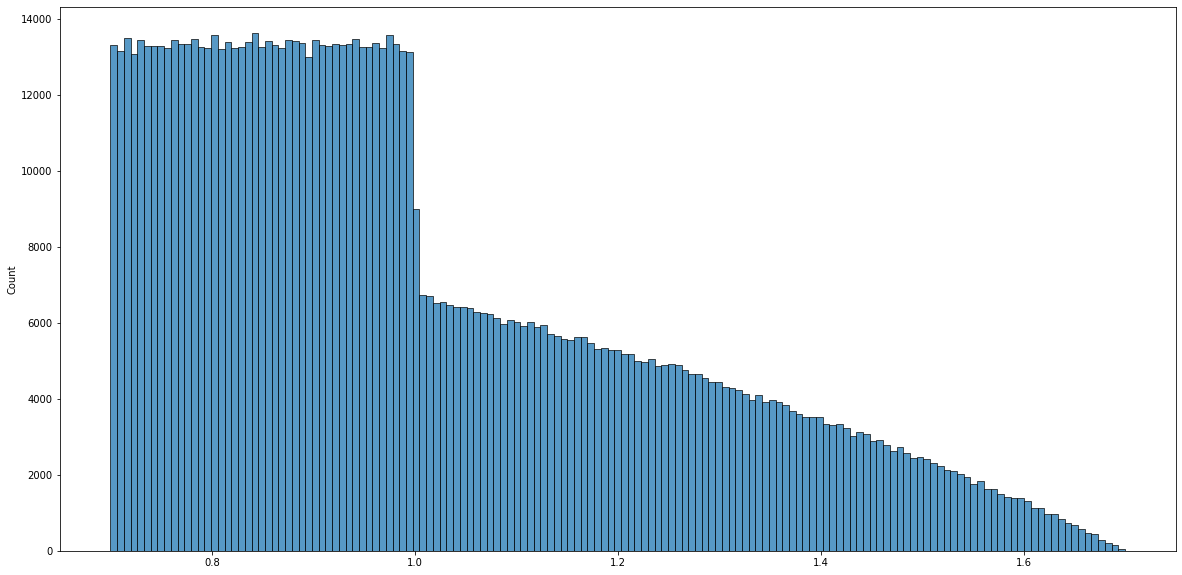

In [15]:
A = np.asarray(simulation(1000000, 0.7))
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(A, ax = ax)
print(f'probability to get busted = {(A>1).sum()/(A.size)}')

probability to get busted = 0.271121


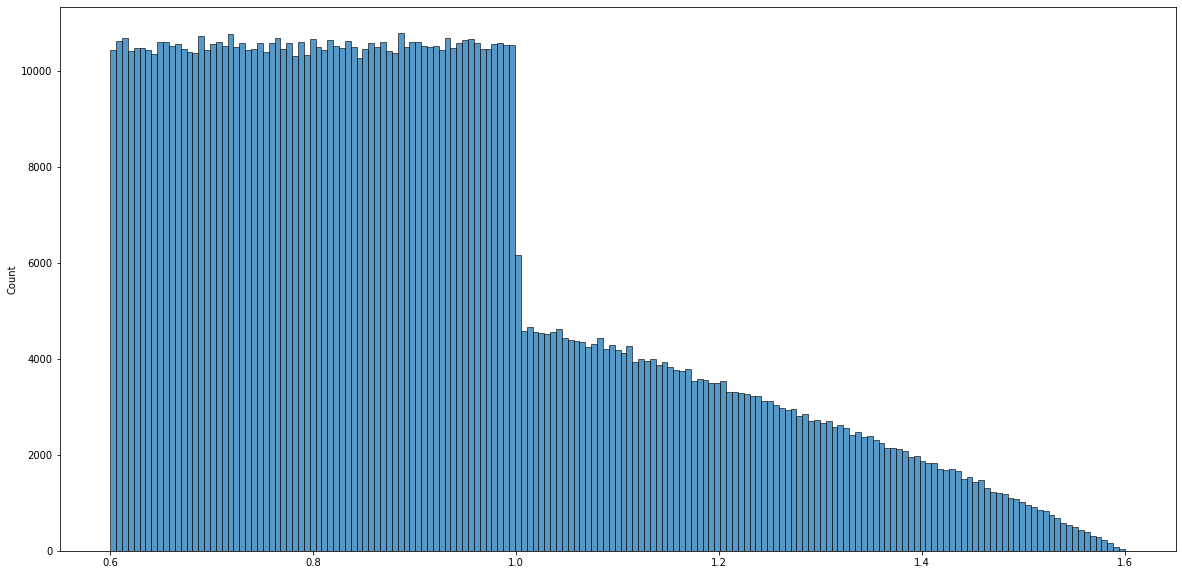

In [16]:
A = np.asarray(simulation(1000000, 0.6))
fig, ax = plt.subplots(figsize = (20,10))
sns.histplot(A, ax = ax)
print(f'probability to get busted = {(A>1).sum()/(A.size)}')

## Game Design

For the simultation, the game is designed below. More strategies and notes will be added in the future.

In [17]:
%%cython
# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION

import numpy as np
cimport numpy as np

from libc.stdlib cimport rand, RAND_MAX

cpdef double draw(double threshold):
    cdef double hand
    hand = 0
    while hand < threshold:
        hand += rand() / float(RAND_MAX)
    return hand

In [18]:
# Strategy class

# Currently, st_type is one of the following

# - Random: Choose a random threshold between input and 1
# - Constant: Constant Threshold
# - BasicLearning: Experimental (will be modified)
# - NE: Nash equilibrium that is previously computed

class Strategy:
    def __init__(self, *args):
        self.st_type = args[0]
        
        if self.st_type == 'Random':
            self.constant = args[1]
            
        elif self.st_type == 'Constant':
            self.constant = args[1]
            
        elif self.st_type == 'BasicLearning':
            self.constant = args[1]
            self.sensitivity = args[2]
            
        elif self.st_type == 'Nash':
            pass
                
    def get_threshold(self, turn, mx):
        return max(mx, self.threshold[turn])
    
    
    def update(self, player_number, n, D):
        
        if self.st_type == 'Random':
            L = len(self.threshold)
            self.threshold[:-1] = (1-self.constant) * np.random.random(L-1) + self.constant
        
        elif self.st_type == 'Constant':
            pass
        
        elif self.st_type == 'BasicLearning':
            game_order = np.where(D['gameTurn'][n] == player_number)[0][0]
            H = D['hands'][n]
            factor = H[player_number] - (H[H<=1].max() if H[player_number] <= 1 else H[H>1].mean())
            self.threshold[game_order] *= np.exp(-self.sensitivity * factor)
        
        elif self.st_type == 'Nash':
            pass
            
    def initialize(self, num_players):
        self.threshold = np.zeros(num_players, dtype = float64)
        
        if self.st_type == 'Random':
            self.threshold[:-1] = (1-self.constant) * np.random.random(num_players - 1) + self.constant
        
        elif self.st_type == 'Constant':
            self.threshold[:-1] = self.constant
            
        elif self.st_type == 'BasicLearning':
            self.threshold[:-1] = self.constant
            
        elif self.st_type == 'Nash':
            self.threshold = generate_Nash_thresholds(num_players)

In [19]:
# Game Class

DATA_DTYPE = np.dtype([
    ('gameTurn', int64),
    ('hands', float64),
    ('winning', float64),
])

class Game:
    def __init__(self, players, num_games):
        self.players = players
        self.num_players = len(players)
        self.num_games = num_games
        self.data = np.zeros((num_games, self.num_players), dtype = DATA_DTYPE)
        self.threshold_history = np.zeros((self.num_players, num_games, self.num_players), dtype = float64)
        
        for P in players:
            P.initialize(self.num_players)
    
    def run(self, verbose = True):
        for n in range(self.num_games):
            self.data['gameTurn'][n,:] = np.random.permutation(self.num_players)
            winner_index = 0
            mx = 0
            for game_order, player_number in enumerate(self.data['gameTurn'][n]):
                hand = 0
                player = self.players[player_number]
                self.threshold_history[player_number, n] = player.threshold
                T = player.get_threshold(game_order, mx)
                hand = draw(T)
                if hand <= 1:
                    winner_index = player_number
                    mx = max(mx, hand)
                self.data['hands'][n, player_number] = hand
            self.data['winning'][n, winner_index] = 1
            for player_number, P in enumerate(self.players):
                if player_number != winner_index:
                    P.update(player_number, n, self.data)
            if verbose and (n+1)%(self.num_games//5) == 0:
                print(f'Game {n+1} is done')

In [20]:
players = [
    ('Random', 0.5),
    ('Random', 0.7),
    ('Constant', 0.7),
    ('Constant', 0.8),
    ('Constant', 0.9),
    ('BasicLearning', 0.6, 0.01),
    ('BasicLearning', 0.7, 0.01),
    ('Nash',),
]

In [21]:
P = np.array([Strategy(*p) for p in players])

In [22]:
G = Game(players = P, num_games = 500000)
G.run()

Game 100000 is done
Game 200000 is done
Game 300000 is done
Game 400000 is done
Game 500000 is done


In [23]:
pd.DataFrame(np.array(G.data['hands']))

,0,1,2,3,4,5,6,7
0,1.225421,1.420717,0.991003,1.584689,1.005210,1.186599,1.838099,1.398590
1,1.141003,0.981242,0.728750,1.474681,1.050703,1.321420,0.733206,1.473051
2,1.148099,1.535232,1.134272,1.202023,0.978524,1.716067,1.554165,1.705924
3,0.837406,1.656871,1.300981,0.912991,1.238794,0.754139,0.979030,1.360965
4,0.966326,1.671835,1.674248,1.593218,1.165661,1.062012,1.175890,1.055752
...,...,...,...,...,...,...,...,...
499995,0.945045,1.204110,1.003720,1.760487,1.507103,1.665209,1.671760,0.972331
499996,1.028748,1.409878,1.193975,0.843448,1.267121,1.074039,0.947577,1.011026
499997,1.212105,1.162931,1.018272,0.822257,0.973831,1.146289,0.913972,1.540444
499998,1.020560,0.976742,1.332750,1.280973,1.331019,1.722371,0.905732,1.262517


,Nash,Constant_0.7,Constant_0.8,BasicLearning_0.7_0.01,BasicLearning_0.6_0.01,Random_0.5,Constant_0.9,Random_0.7
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
499995,66485.0,66349.0,65922.0,62381.0,62122.0,60062.0,59728.0,56947.0
499996,66485.0,66349.0,65922.0,62382.0,62122.0,60062.0,59728.0,56947.0
499997,66485.0,66349.0,65922.0,62382.0,62122.0,60062.0,59729.0,56947.0
499998,66485.0,66349.0,65922.0,62382.0,62122.0,60062.0,59729.0,56948.0


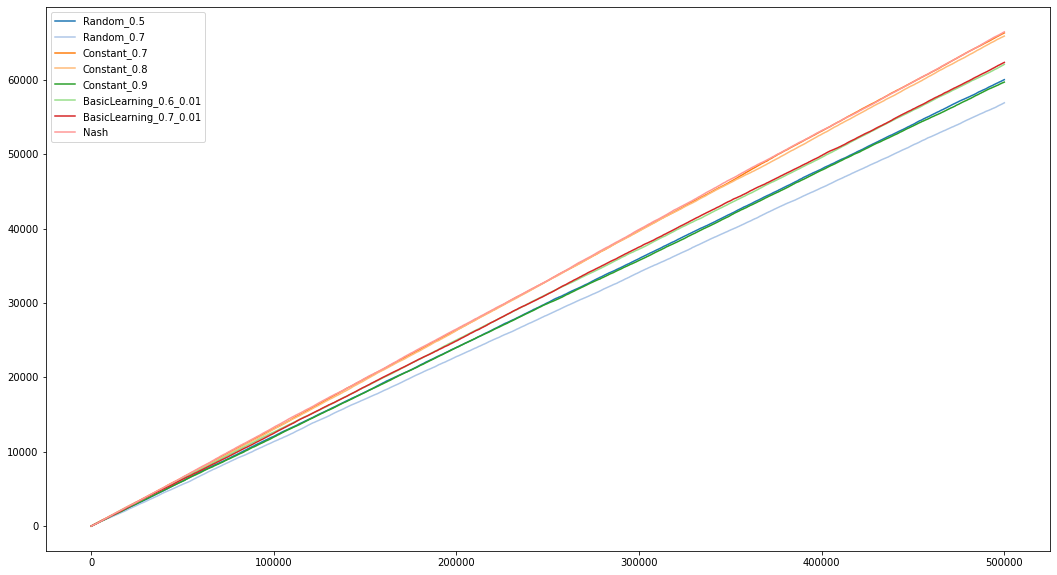

In [24]:
result = pd.DataFrame(G.data['winning']).cumsum(axis = 0)
result.columns = ['_'.join([str(x) for x in p]) for p in players]
fig, ax = plt.subplots()
ax.set_prop_cycle(color = sns.color_palette("tab20"))
result.plot(ax = ax, figsize = (18,10))
result.sort_values(by = result.last_valid_index(), axis = 1, ascending = False)

<AxesSubplot:>

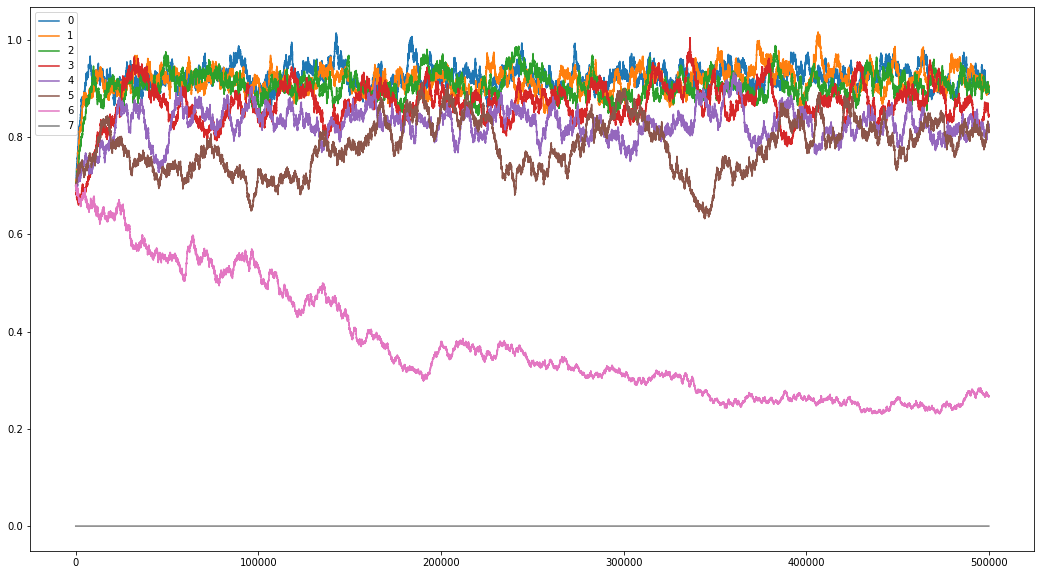

In [25]:
pd.DataFrame(G.threshold_history[-2]).plot(figsize = (18,10))